# **Merging datasets using transitive properties (Part 2).** #

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns


#  Load Datasets  #

In [15]:

transactions = pd.read_csv('/content/customer_transactions.csv')
social_profiles = pd.read_csv('/content/customer_social_profiles.csv')
id_mapping = pd.read_csv('/content/id_mapping.csv')

#Handling duplicate mappings (Conflict Resolution)

Keeping first mapping where legacy IDs map to multiple new IDs

In [16]:

id_mapping_clean = id_mapping.drop_duplicates(subset='customer_id_legacy', keep='first')


# Performing transitive merge between customer_transactions and id_mapping

In [17]:

transactions_mapped = pd.merge(
    transactions,
    id_mapping_clean,
    on='customer_id_legacy',
    how='left'
)

# Merging with customer social profiles

In [18]:
##(inner join to keep only matching records)
merged_data = pd.merge(
    transactions_mapped,
    social_profiles,
    on='customer_id_new',
    how='inner'
)

#  **Data Cleaning & Feature Engineering** #

# Drop rows where key columns have missing values


In [19]:

merged_data_clean = merged_data.dropna(subset=['customer_id_new', 'social_media_platform'])



# Normalize features for engagement score

In [20]:

scaler = MinMaxScaler()
features_to_scale = ['engagement_score', 'purchase_interest_score']
merged_data_clean[features_to_scale] = scaler.fit_transform(merged_data_clean[features_to_scale])



#Create composite Customer Engagement Score

In [21]:
weights = {'engagement_score': 0.5, 'purchase_interest_score': 0.5}
merged_data_clean['customer_engagement_score'] = sum(
    merged_data_clean[feature] * weight for feature, weight in weights.items()
)

#Time-based aggregations


In [22]:

merged_data_clean['purchase_date'] = pd.to_datetime(merged_data_clean['purchase_date'])

# Monthly spending per customer
merged_data_clean['monthly_spending'] = merged_data_clean.groupby([
    'customer_id_new',
    pd.Grouper(key='purchase_date', freq='M')
])['purchase_amount'].transform('sum')



<ipython-input-22-b7a77ed47b73>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.Grouper(key='purchase_date', freq='M')


# Moving average of purchases (3-transaction window)

In [23]:

merged_data_clean['purchase_moving_avg'] = merged_data_clean.groupby(
    'customer_id_new'
)['purchase_amount'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)


# Remove duplicates

In [24]:

merged_data_clean = merged_data_clean.drop_duplicates()


# **Data Integrity Checks**#



In [25]:
#looking for dublicates
assert merged_data_clean.duplicated().sum() == 0, "Duplicate rows found"

#Validate platform categories
valid_platforms = ['LinkedIn', 'Twitter', 'Facebook', 'Instagram', 'TikTok']
platform_check = merged_data_clean['social_media_platform'].isin(valid_platforms)
assert platform_check.all(), "Invalid social media platforms detected"

# **Statistical Summarization & Visualizations** #

       customer_id_legacy  transaction_id  purchase_amount  \
count          179.000000      179.000000       179.000000   
mean           152.005587     1072.346369       291.932961   
min            101.000000     1001.000000        77.000000   
25%            125.000000     1031.000000       192.000000   
50%            152.000000     1071.000000       280.000000   
75%            186.000000     1111.000000       401.000000   
max            199.000000     1150.000000       495.000000   
std             32.345310       43.767294       115.979735   

                       purchase_date  customer_rating  engagement_score  \
count                            179       167.000000        179.000000   
mean   2024-03-12 08:18:46.256983296         3.060479          0.549424   
min              2024-01-01 00:00:00         1.000000          0.000000   
25%              2024-01-31 00:00:00         2.100000          0.367347   
50%              2024-03-11 00:00:00         3.200000          0.5

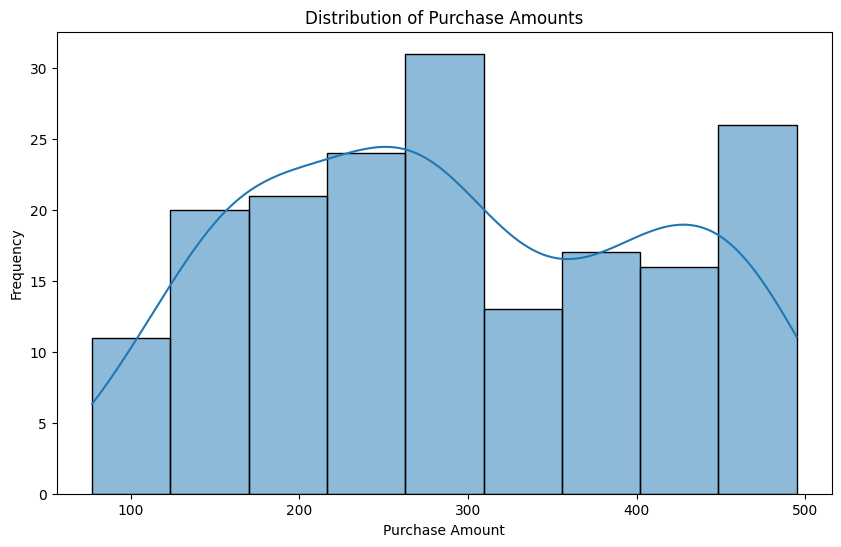

In [26]:
#visualise numeral data
print(merged_data_clean.describe())

# Ploting the distribution of purchase amounts
plt.figure(figsize=(10, 6))
sns.histplot(merged_data_clean['purchase_amount'], kde=True)
plt.title('Distribution of Purchase Amounts')
plt.xlabel('Purchase Amount')
plt.ylabel('Frequency')
plt.show()

#**Ploting the Correlation Heatmap**#

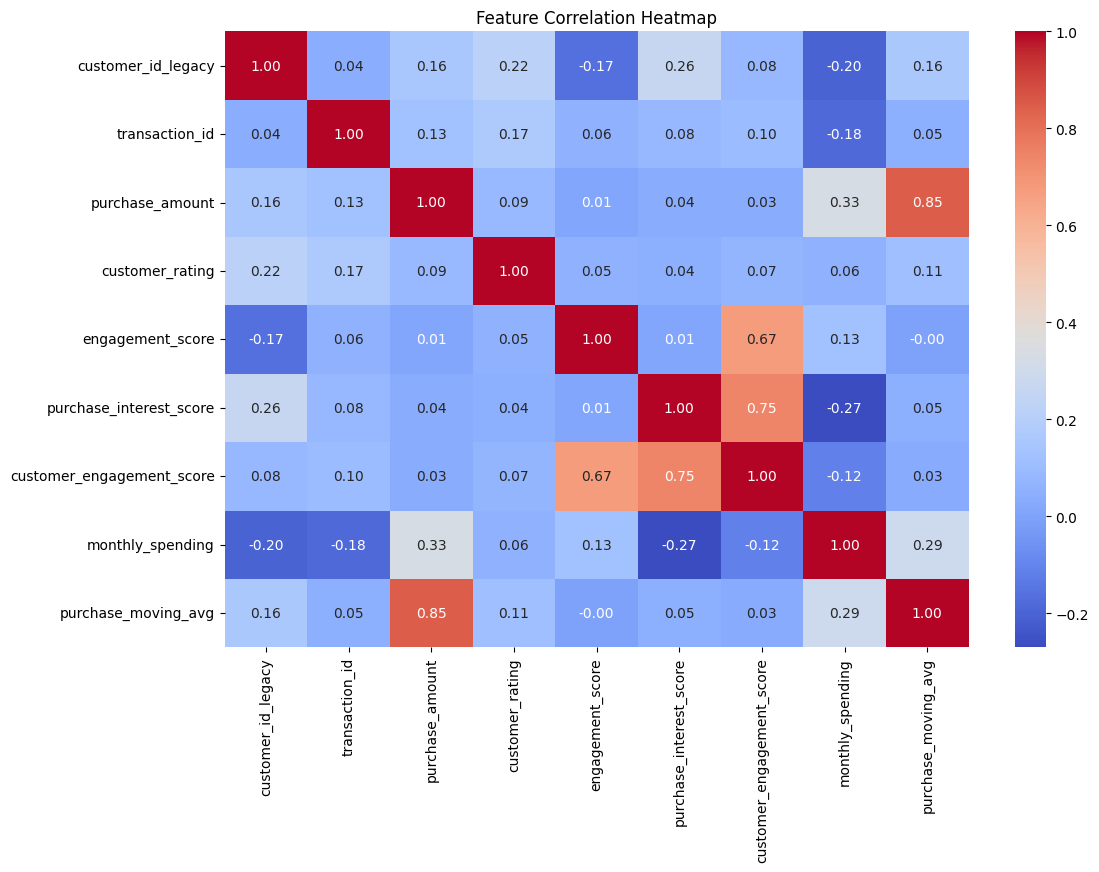

In [27]:
numeric_columns = merged_data_clean.select_dtypes(include=['number']).columns
correlation_matrix = merged_data_clean[numeric_columns].corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


#**Feature Selection**

In [28]:
# Check for highly correlated features (you can adjust the threshold as needed)
high_corr_threshold = 0.8
highly_correlated_features = correlation_matrix[correlation_matrix > high_corr_threshold].stack().index.tolist()

print(f"Highly correlated features: {highly_correlated_features}")


Highly correlated features: [('customer_id_legacy', 'customer_id_legacy'), ('transaction_id', 'transaction_id'), ('purchase_amount', 'purchase_amount'), ('purchase_amount', 'purchase_moving_avg'), ('customer_rating', 'customer_rating'), ('engagement_score', 'engagement_score'), ('purchase_interest_score', 'purchase_interest_score'), ('customer_engagement_score', 'customer_engagement_score'), ('monthly_spending', 'monthly_spending'), ('purchase_moving_avg', 'purchase_amount'), ('purchase_moving_avg', 'purchase_moving_avg')]


#**Export Final Data**#

In [29]:
merged_data_clean.to_csv(
    '/content/final_customer_data_group15.csv',
    index=False
)

# **Code for feature engineering & transformation.**